In [56]:
from scipy.optimize import curve_fit
import numpy as np

def power_law(q, K, P):
    return K * q ** (-P)

def compute_porod_exponent_sf(data, q_min, q_max):
    # Compute the structure factor
    structure_factor = np.abs(np.fft.fftn(data)) ** 2

    # Compute the magnitude of the wavevector for each point in the structure factor
    q_values = np.sqrt(
        np.sum(
            np.array(np.meshgrid(*[np.fft.fftfreq(n) * n for n in data.shape]))
            ** 2,
            axis=0,
        )
    )

    # Flatten the q_values and structure_factor arrays for curve fitting
    q_values = q_values.flatten()
    structure_factor = structure_factor.flatten()
    print(min(q_values), max(q_values))

    # Fit the tail of the structure factor to a power law
    mask = (q_values >= q_min) & (q_values <= q_max)
    popt, pcov = curve_fit(power_law, q_values[mask], structure_factor[mask], bounds=([0, 0], [np.inf, 4]))

    # The second parameter of the fit is the Porod's exponent
    return popt[1]


def porods_law_over_time_sf(data_list, q_min=1.0, q_max=10.0):
    # Initialize an array to hold the Porod's exponents
    porod_exponents = np.zeros(len(data_list))

    # Loop over time steps
    for i in range(len(data_list)):
        porod_exponents[i] = compute_porod_exponent_sf(data_list[i], q_min, q_max)

    return porod_exponents

In [57]:
import numpy as np
from scipy.optimize import curve_fit
from numba import jit, prange
from scipy.signal import fftconvolve

def power_law(q, K, P):
    return K * q ** (-P)

def compute_structure_factor(data):
    # Compute the autocorrelation function using FFT
    autocorr = fftconvolve(data, data[::-1, ::-1], mode='same')

    # Compute the structure factor as the square of the absolute value of the FFT of the autocorrelation
    structure_factor = np.abs(np.fft.fftshift(np.fft.fftn(autocorr))) ** 2

    return structure_factor

def compute_porod_exponent(data, q_min, q_max):
    # Compute the structure factor
    structure_factor = compute_structure_factor(data)

    # Compute the magnitude of the wavevector for each point in the structure factor
    q_values = np.sqrt(
        np.sum(
            np.array(np.meshgrid(*[np.fft.fftfreq(n) * n for n in data.shape]))
            ** 2,
            axis=0,
        )
    )

    # Flatten the q_values and structure_factor arrays for curve fitting
    q_values = q_values.flatten()
    structure_factor = structure_factor.flatten()

    # Fit the tail of the structure factor to a power law
    mask = (q_values >= q_min) & (q_values <= q_max)
    popt, pcov = curve_fit(power_law, q_values[mask], structure_factor[mask], bounds=([0, 0], [np.inf, 4]))

    # The second parameter of the fit is the Porod's exponent
    return popt[1]

def porods_law_over_time(data_list, q_min=1.0, q_max=10.0):
    """
    Calculate Porod's law over time for a system represented by a list of 2D numpy arrays.
    Each array in the list should represent the system state at a different time.

    Porod's law is a power law relationship that describes the scattering intensity of a system
    with two phases as a function of the scattering vector q. The law is given by:

        I(q) = K * q^(-P)

    where I(q) is the scattering intensity, q is the magnitude of the scattering vector, K is a
    constant, and P is the Porod's exponent. For a system with a sharp interface between two phases,
    P is expected to be 4.

    In this function, the scattering intensity I(q) is approximated by the structure factor S(q),
    which is the Fourier transform of the autocorrelation function G(r). G(r) is 1 where the two
    points separated by distance r are in the same phase, and -1 where they are in different phases.

    The function fits the tail of the structure factor to a power law to find the Porod's exponent
    for each time step. The tail is defined by the range of q values between q_min and q_max.

    Parameters:
    data_list (list of 2D numpy arrays): The system state at different time steps.
    q_min (float, optional): The minimum q value for the power law fit. Default is 1.0.
    q_max (float, optional): The maximum q value for the power law fit. Default is 10.0.

    Returns:
    numpy array: The Porod's exponents for each time step.
    """
    # Initialize an array to hold the Porod's exponents
    porod_exponents = np.zeros(len(data_list))

    # Loop over time steps
    for i in prange(len(data_list)):
        porod_exponents[i] = compute_porod_exponent(data_list[i], q_min, q_max)

    return porod_exponents

In [58]:
import numpy as np


def read_and_process_file(filename):
    with open(filename, "r") as file:
        # Read the first line of the file
        first_line = next(file).strip()[:-1]
        dimension, x_units, y_units, x_start, x_end, y_start, y_end, time_step = map(
            float, first_line.split()
        )

        blocks = []
        block = []
        for line in file:
            stripped_line = line.strip()
            if stripped_line.endswith("@"):  # line is a header
                if block:  # if there's a previous block, add it to the list
                    blocks.append((time_step, np.array(block, dtype=float)))
                time_step = int(stripped_line.split("@")[0])
                block = []  # start a new block with the header
            else:  # line is part of the matrix
                block.append(list(map(float, stripped_line.split())))
        if block:  # add the last block if it's not empty
            blocks.append((time_step, np.array(block, dtype=float)))

    # Process each block
    data = []
    for time_step, block in blocks:
        data.append((time_step, process_block(block)))

    return data


def process_block(block):
    # Discard the boundary, 3 layers deep, on each edge
    processed_block = block[3:-3, 3:-3]

    # Round the data to the nearest integer (0 or 1)
    adjusted_block = np.where(processed_block < 0, 0, 1)
    return adjusted_block


# Call the function with the path to your file
time_steps, data = zip(*read_and_process_file("data0"))

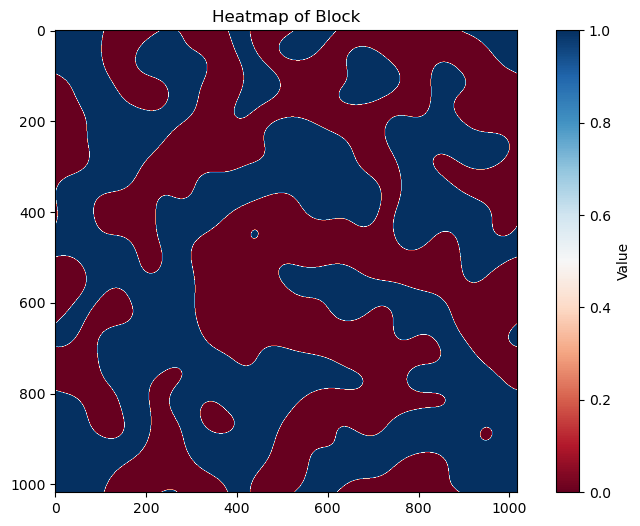

In [59]:
import matplotlib.pyplot as plt

def draw_heatmap(block, cmap='RdBu'):
    plt.figure(figsize=(10, 6))
    plt.imshow(block, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title("Heatmap of Block")
    plt.show()

# Call the function with a selected block
# For example, the first block in the data list
draw_heatmap(data[10])

In [63]:
porods_exponents = porods_law_over_time_sf(data, 50, 200)

0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.8347032479053
0.0 719.83

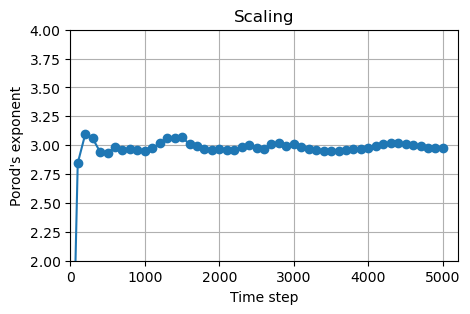

In [71]:
import matplotlib.pyplot as plt

def plot_porods_law(porods_exponents):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(np.asarray(time_steps) * 0.1, porods_exponents, marker='o')
    ax.set_xlim([0, 5200])
    ax.set_ylim([2, 4])

    ax.set_title("Scaling")
    ax.set_xlabel('Time step')
    ax.set_ylabel("Porod's exponent")
    ax.grid(True)

# Call the function with the output of porods_law_over_time
plot_porods_law(porods_exponents)